<a href="https://colab.research.google.com/github/Genananana/VVSU_BPM-22-1/blob/main/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# МЛ Практика 3: Подбор признаков и валидация моделей

## **Цель занятия:**
Изучить методы поиска значимых признаков в данных. На практике мы проведем анализ целевой переменной **Y**, применим методы для поиска значимых признаков, обучим линейную модель, проанализируем результат и оценим валидность модели.

## **Задание состоит из следующих частей:**
1. Обработка выбросов;
1. Поиск значимых признаков с использованием библиотеки **sklearn**.
2. Обучение логистической регресси модели и оценка ее точности.
6. Кросс-валидация с использованием разных методов (K-fold, ShuffleSplit, test-train-validation)

## 1: Загрузка библиотек и предобратка данных

In [1]:
!pip install pandas scikit-learn seaborn scipy

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.feature_selection import SelectKBest, chi2, RFE, SelectFromModel

In [5]:
# Загрузка набора данных
df = pd.read_csv('/content/employee (1).csv')

In [6]:
df

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,department,salary,left
0,0.38,0.53,2,157,3,0,0,sales,low,1
1,0.80,0.86,5,262,6,0,0,sales,medium,1
2,0.11,0.88,7,272,4,0,0,sales,medium,1
3,0.72,0.87,5,223,5,0,0,sales,low,1
4,0.37,0.52,2,159,3,0,0,sales,low,1
...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,0,support,low,1
14995,0.37,0.48,2,160,3,0,0,support,low,1
14996,0.37,0.53,2,143,3,0,0,support,low,1
14997,0.11,0.96,6,280,4,0,0,support,low,1


In [21]:
df['is_best_employee'] = np.where(df['time_spend_company'] >= 4, 1, 0)
df.is_best_employee = df.is_best_employee.astype('category')
df['department'] = df['department'].astype('category')
df['salary'] = df['salary'].astype('category')

In [22]:
Y = df['is_best_employee'] # выбираем целевую переменную (категориальную)
X = df.drop('is_best_employee', axis=1) # переменные для проверки влияния

# В моем случае я дропаю базовую переменную, а не только. Y
X = X.drop('time_spend_company', axis=1)

In [23]:
df.drop('time_spend_company', axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   satisfaction_level     14999 non-null  float64 
 1   last_evaluation        14999 non-null  float64 
 2   number_project         14999 non-null  int64   
 3   average_montly_hours   14999 non-null  int64   
 4   Work_accident          14999 non-null  int64   
 5   promotion_last_5years  14999 non-null  int64   
 6   department             14999 non-null  category
 7   salary                 14999 non-null  category
 8   left                   14999 non-null  int64   
 9   is_best_employee       14999 non-null  category
dtypes: category(3), float64(2), int64(5)
memory usage: 864.9 KB


In [24]:
df

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,department,salary,left,is_best_employee
0,0.38,0.53,2,157,3,0,0,sales,low,1,0
1,0.80,0.86,5,262,6,0,0,sales,medium,1,1
2,0.11,0.88,7,272,4,0,0,sales,medium,1,1
3,0.72,0.87,5,223,5,0,0,sales,low,1,1
4,0.37,0.52,2,159,3,0,0,sales,low,1,0
...,...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,0,support,low,1,0
14995,0.37,0.48,2,160,3,0,0,support,low,1,0
14996,0.37,0.53,2,143,3,0,0,support,low,1,0
14997,0.11,0.96,6,280,4,0,0,support,low,1,1


## 2: масштабирование признаков

In [25]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   satisfaction_level     14999 non-null  float64 
 1   last_evaluation        14999 non-null  float64 
 2   number_project         14999 non-null  int64   
 3   average_montly_hours   14999 non-null  int64   
 4   Work_accident          14999 non-null  int64   
 5   promotion_last_5years  14999 non-null  int64   
 6   department             14999 non-null  category
 7   salary                 14999 non-null  category
 8   left                   14999 non-null  int64   
dtypes: category(2), float64(2), int64(5)
memory usage: 850.2 KB


In [26]:
# Создаем копию данных
X_processed = X.copy()

category_columns: list[str] = X_processed.select_dtypes(include=['category']).columns # собираем колонки помеченные как category

# Применяем One-Hot Encoding
X_processed = pd.get_dummies(X_processed, columns=category_columns,drop_first=True) # drop_first=True позволяет избежать мультиколлинеарности, удаляя первый уровень категориальной переменной.


In [27]:
X_processed

,satisfaction_level,last_evaluation,number_project,average_montly_hours,Work_accident,promotion_last_5years,left,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_low,salary_medium
0,0.38,0.53,2,157,0,0,1,False,False,False,False,False,False,True,False,False,True,False
1,0.80,0.86,5,262,0,0,1,False,False,False,False,False,False,True,False,False,False,True
2,0.11,0.88,7,272,0,0,1,False,False,False,False,False,False,True,False,False,False,True
3,0.72,0.87,5,223,0,0,1,False,False,False,False,False,False,True,False,False,True,False
4,0.37,0.52,2,159,0,0,1,False,False,False,False,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,0,0,1,False,False,False,False,False,False,False,True,False,True,False
14995,0.37,0.48,2,160,0,0,1,False,False,False,False,False,False,False,True,False,True,False
14996,0.37,0.53,2,143,0,0,1,False,False,False,False,False,False,False,True,False,True,False
14997,0.11,0.96,6,280,0,0,1,False,False,False,False,False,False,False,True,False,True,False


In [28]:
# Выбираем числовые признаки
numeric_features = X_processed.select_dtypes(include=['float64']).columns.tolist()

# Инициализируем scaler
scaler = MinMaxScaler()

# Применяем нормализацию
X_processed[numeric_features] = scaler.fit_transform(X_processed[numeric_features])


In [29]:
X_processed

,satisfaction_level,last_evaluation,number_project,average_montly_hours,Work_accident,promotion_last_5years,left,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_low,salary_medium
0,0.318681,0.265625,2,157,0,0,1,False,False,False,False,False,False,True,False,False,True,False
1,0.780220,0.781250,5,262,0,0,1,False,False,False,False,False,False,True,False,False,False,True
2,0.021978,0.812500,7,272,0,0,1,False,False,False,False,False,False,True,False,False,False,True
3,0.692308,0.796875,5,223,0,0,1,False,False,False,False,False,False,True,False,False,True,False
4,0.307692,0.250000,2,159,0,0,1,False,False,False,False,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,0.340659,0.328125,2,151,0,0,1,False,False,False,False,False,False,False,True,False,True,False
14995,0.307692,0.187500,2,160,0,0,1,False,False,False,False,False,False,False,True,False,True,False
14996,0.307692,0.265625,2,143,0,0,1,False,False,False,False,False,False,False,True,False,True,False
14997,0.021978,0.937500,6,280,0,0,1,False,False,False,False,False,False,False,True,False,True,False


## 3: Очистка данных и удаление выбросов

Важным шагом в машинном обучении - является очистка и удаление данных от выбросов.

### Методы обработки выбросов:

1. **Метод на основе медианы и межквартильного размаха (IQR)**:
   - **Как работает**:
     Метод основан на расчете межквартильного размаха (IQR), который вычисляется как разница между третьим (75-й перцентиль) и первым квартилем (25-й перцентиль). Данные считаются выбросами, если они выходят за пределы диапазона \([Q1 - 1.5 * IQR , Q3 + 1.5 * IQR]\).
   - **Зачем это нужно**:
     Выбросы могут серьезно искажать результаты моделей, особенно тех, которые основаны на средних значениях или предполагают нормальное распределение данных.
   - **Когда лучше использовать**:
     - Когда данные содержат **немного выбросов** и имеют **асимметричное распределение**.
     - Метод медианы и IQR более устойчив к выбросам по сравнению с методом, основанным на среднем значении, так как медиана меньше подвержена влиянию экстремальных значений.
     - Хорошо подходит для набора данных, которые не распределены нормально (например, зарплаты или цены на недвижимость).

2. **Метод на основе среднего (Mean)**:
   - **Как работает**:
     Метод использует средние значения и удаляет те признаки или записи, которые значительно отклоняются от среднего. Чаще всего это делается с помощью установления порога (например, данные, которые превышают 2 или 3 средних значения, считаются выбросами).
   - **Зачем это нужно**:
     Выбросы, сильно отличающиеся от средних значений, могут существенно влиять на такие модели, как линейная регрессия, так как среднее значение сильно чувствительно к экстремальным точкам.
   - **Когда лучше использовать**:
     - Когда данные имеют **нормальное распределение** или приближены к нормальному.
     - Подходит, если данные содержат **много выбросов**, и вам нужно жестче ограничить их влияние на модель.

### Как выбрать метод:

- **Если данные асимметричны** или распределены с "хвостами" (например, распределение доходов или цен), лучше использовать **метод на основе медианы и IQR**, так как медиана не чувствительна к выбросам и лучше описывает такие наборы данных.
  
- **Если данные нормально распределены** и важно учитывать всю выборку, даже если есть выбросы, можно использовать **метод на основе среднего**. Этот метод будет точнее отражать центр распределения в симметричных данных и позволит выявить значительные отклонения от него.

Оба метода помогают улучшить производительность моделей машинного обучения, обеспечивая более точное представление данных для анализа и обучения.

### Для начала определеим функцию обучения с оценкой качества (для простоты)

In [30]:
from sklearn.model_selection import cross_val_score

def train_and_evaluate(X, Y):
    # Разделение данных на обучающую и тестовую выборки
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.2, random_state=42, stratify=Y)

    # Инициализация модели
    model = LogisticRegression(max_iter=1000)

    # Обучение модели
    model.fit(X_train, Y_train)

    # Предсказания на обучающей выборке
    Y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(Y_train, Y_train_pred)

    # Предсказания на тестовой выборке
    Y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(Y_test, Y_test_pred)

    # Вывод результатов
    print(f"Точность на обучающей выборке: {train_accuracy:.4f}")
    print(f"Точность на тестовой выборке: {test_accuracy:.4f}")

    # Классификационный отчет
    print("\nКлассификационный отчет на тестовой выборке:")
    print(classification_report(Y_test, Y_test_pred))

    return model


In [31]:
train_and_evaluate(X_processed, Y)

Точность на обучающей выборке: 0.7681
Точность на тестовой выборке: 0.7787

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.77      0.93      0.84      1938
           1       0.79      0.51      0.62      1062

    accuracy                           0.78      3000
   macro avg       0.78      0.72      0.73      3000
weighted avg       0.78      0.78      0.76      3000



LogisticRegression(max_iter=1000)

### Метод 1: удаление на основе медианы

In [32]:
# Функция для удаления выбросов на основе межквартильного размаха (1.5 IQR)
def remove_outliers_based_on_iqr(X, y, iqr_multiplier=1.5):
    # Убедимся, что работаем только с числовыми данными
    X_numeric = X.select_dtypes(include=['number'])

    # Рассчитываем первый и третий квартили для каждой числовой переменной
    Q1 = X_numeric.quantile(0.25)
    Q3 = X_numeric.quantile(0.75)

    # Вычисляем межквартильный размах (IQR)
    IQR = Q3 - Q1

    # Оставляем только те значения, которые находятся в диапазоне [Q1 - 1.5*IQR, Q3 + 1.5*IQR]
    X_filtered = X_numeric[~((X_numeric < (Q1 - iqr_multiplier * IQR)) | (X_numeric > (Q3 + iqr_multiplier * IQR))).any(axis=1)]

    # Синхронизируем y с отфильтрованными X
    y_filtered = y.loc[X_filtered.index]

    return X_filtered, y_filtered


In [33]:
X_iqr, y_iqr = remove_outliers_based_on_iqr(X_processed, Y, iqr_multiplier=3)

In [34]:
X_processed.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,Work_accident,promotion_last_5years,left
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.574542,0.556409,3.803054,201.050337,0.144610,0.021268,0.238083
std,0.273220,0.267452,1.232592,49.943099,0.351719,0.144281,0.425924
min,0.000000,0.000000,2.000000,96.000000,0.000000,0.000000,0.000000
25%,0.384615,0.312500,3.000000,156.000000,0.000000,0.000000,0.000000
50%,0.604396,0.562500,4.000000,200.000000,0.000000,0.000000,0.000000
75%,0.802198,0.796875,5.000000,245.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,1.000000,1.000000,1.000000


In [35]:
X_iqr.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,Work_accident,promotion_last_5years,left
count,9200.000000,9200.000000,9200.000000,9200.000000,9200.0,9200.0,9200.0
mean,0.634118,0.556479,3.785000,199.046739,0.0,0.0,0.0
std,0.238334,0.252735,0.976444,45.605565,0.0,0.0,0.0
min,0.032967,0.000000,2.000000,96.000000,0.0,0.0,0.0
25%,0.494505,0.343750,3.000000,162.000000,0.0,0.0,0.0
50%,0.659341,0.562500,4.000000,198.000000,0.0,0.0,0.0
75%,0.824176,0.765625,4.000000,238.000000,0.0,0.0,0.0
max,1.000000,1.000000,6.000000,287.000000,0.0,0.0,0.0


In [36]:
train_and_evaluate(X_iqr, y_iqr)

Точность на обучающей выборке: 0.7409
Точность на тестовой выборке: 0.7467

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.75      0.97      0.84      1307
           1       0.73      0.20      0.31       533

    accuracy                           0.75      1840
   macro avg       0.74      0.59      0.58      1840
weighted avg       0.74      0.75      0.69      1840



LogisticRegression(max_iter=1000)

### ⏰ **Провести анализ выводов, посмотреть как измеились переменные и описать результат**

## Анализ результатов двух моделей LogisticRegression

Модель 1:

* Точность на обучающей выборке: 0.7681
* Точность на тестовой выборке: 0.7787
* Классификационный отчет (test):
    * Precision (точность) для класса 0: 0.77 - модель правильно предсказывает класс 0 в 77% случаев.
    * Recall (полнота) для класса 0: 0.93 - модель обнаруживает 93% случаев класса 0.
    * F1-score для класса 0: 0.84 - компромисс между точностью и полнотой для класса 0.
    * Precision (точность) для класса 1: 0.79 - модель правильно предсказывает класс 1 в 79% случаев.
    * Recall (полнота) для класса 1: 0.51 - модель обнаруживает 51% случаев класса 1.
    * F1-score для класса 1: 0.62 - компромисс между точностью и полнотой для класса 1.
    * Accuracy (общая точность): 0.78 - модель правильно предсказывает класс для 78% тестовых данных.

Модель 2:

* Точность на обучающей выборке: 0.7409
* Точность на тестовой выборке: 0.7467
* Классификационный отчет (test):
    * Precision (точность) для класса 0: 0.75 - модель правильно предсказывает класс 0 в 75% случаев.
    * Recall (полнота) для класса 0: 0.97 - модель обнаруживает 97% случаев класса 0.
    * F1-score для класса 0: 0.84 - компромисс между точностью и полнотой для класса 0.
    * Precision (точность) для класса 1: 0.73 - модель правильно предсказывает класс 1 в 73% случаев.
    * Recall (полнота) для класса 1: 0.20 - модель обнаруживает только 20% случаев класса 1.
    * F1-score для класса 1: 0.31 - компромисс между точностью и полнотой для класса 1.
    * Accuracy (общая точность): 0.75 - модель правильно предсказывает класс для 75% тестовых данных.

Сравнение:

* Модель 1 показывает более высокую точность: Точность на тестовой выборке у модели 1 (0.7787) выше, чем у модели 2 (0.7467).
* Модель 1 лучше предсказывает класс 1: Модель 1 имеет более высокую полноту (recall) для класса 1 (0.51), чем модель 2 (0.20).
* Модель 2 имеет более высокую полноту для класса 0: Модель 2 имеет более высокую полноту (recall) для класса 0 (0.97), чем модель 1 (0.93).

Изменение переменных:

Вероятно, разница в результатах связана с различиями в данных, на которых обучались модели.

* Разные признаки: Возможно, модели были обучены на разных наборах признаков.
* Разные данные: Возможно, модели обучались на разных выборках данных (разное распределение классов, разные значения признаков).
* Разные гиперпараметры: Хотя в коде указано, что `max_iter=1000`, в остальном гиперпараметры могут отличаться (например, `C`, `penalty`).

Результат:

* Модель 1 более точна: Модель 1 показывает более высокую точность на тестовой выборке и лучше справляется с предсказанием класса 1.
* Выбор модели зависит от приоритетов: Если важнее повысить полноту предсказания класса 1, то модель 1 будет предпочтительнее. Если важно повысить полноту предсказания класса 0, то модель 2 будет более подходящей.

Дополнительные шаги:

1. Изучение данных: Проанализируйте, на каких данных обучались модели, какие признаки использовались, и как распределились классы.
2. Эксперименты: Попробуйте обучить обе модели на одинаковых данных, с одинаковыми признаками и гиперпараметрами. Это поможет понять, действительно ли разница в результатах связана с различиями в данных или настройках моделей.
3. Дополнительная оптимизация: Используйте методы оптимизации гиперпараметров, чтобы найти оптимальные настройки для каждой из моделей.
4. Визуализация: Постройте графики ROC-кривых для обеих моделей, чтобы визуализировать их способность различать классы.

В заключение: Обе модели LogisticRegression показали неплохую точность, но модель 1 превосходит модель 2 по точности на тестовой выборке и по полноте предсказания класса 1. Необходимо провести дополнительные исследования, чтобы определить, какая модель лучше всего подходит для конкретной задачи.

### Метод 2: удаление на основе среднего

In [37]:
# Функция для удаления выбросов на основе среднего значения

def remove_outliers_based_on_mean(X, y, mean_multiplier=2):
    # Убедимся, что работаем только с числовыми данными
    X_numeric = X.select_dtypes(include=['number'])

    # Рассчитываем среднее значение и стандартное отклонение для каждой переменной
    mean_values = X_numeric.mean()
    std_values = X_numeric.std()

    # Устанавливаем верхний и нижний пороги на основе среднего значения и множителя стандартного отклонения
    lower_threshold = mean_values - mean_multiplier * std_values
    upper_threshold = mean_values + mean_multiplier * std_values

    # Фильтруем наблюдения, которые находятся в пределах этих порогов по всем признакам
    X_filtered = X_numeric[~((X_numeric < lower_threshold) | (X_numeric > upper_threshold)).any(axis=1)]

    # Синхронизируем y с отфильтрованными X
    y_filtered = y.loc[X_filtered.index]

    return X_filtered, y_filtered

In [38]:
X_mean, y_mean = remove_outliers_based_on_mean(X_processed.copy(), Y.copy())

In [39]:
X_processed.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,Work_accident,promotion_last_5years,left
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.574542,0.556409,3.803054,201.050337,0.144610,0.021268,0.238083
std,0.273220,0.267452,1.232592,49.943099,0.351719,0.144281,0.425924
min,0.000000,0.000000,2.000000,96.000000,0.000000,0.000000,0.000000
25%,0.384615,0.312500,3.000000,156.000000,0.000000,0.000000,0.000000
50%,0.604396,0.562500,4.000000,200.000000,0.000000,0.000000,0.000000
75%,0.802198,0.796875,5.000000,245.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,1.000000,1.000000,1.000000


In [40]:
X_mean.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,Work_accident,promotion_last_5years,left
count,11589.000000,11589.000000,11589.000000,11589.000000,11589.0,11589.0,11589.000000
mean,0.608622,0.543887,3.626629,196.418845,0.0,0.0,0.216844
std,0.240363,0.266886,1.101487,46.968389,0.0,0.0,0.412113
min,0.032967,0.031250,2.000000,102.000000,0.0,0.0,0.000000
25%,0.428571,0.296875,3.000000,154.000000,0.0,0.0,0.000000
50%,0.626374,0.531250,4.000000,194.000000,0.0,0.0,0.000000
75%,0.813187,0.781250,4.000000,239.000000,0.0,0.0,0.000000
max,1.000000,1.000000,6.000000,300.000000,0.0,0.0,1.000000


In [41]:
train_and_evaluate(X_mean, y_mean)

Точность на обучающей выборке: 0.7619
Точность на тестовой выборке: 0.7692

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.77      0.94      0.85      1601
           1       0.75      0.38      0.50       717

    accuracy                           0.77      2318
   macro avg       0.76      0.66      0.68      2318
weighted avg       0.77      0.77      0.74      2318



LogisticRegression(max_iter=1000)

### ⏰ **Провести анализ выводов, посмотреть как измеились переменные и описать результат**

## Анализ двух моделей LogisticRegression

Модель 1:

* Точность на обучающей выборке: 0.7681
* Точность на тестовой выборке: 0.7787
* Классификационный отчет (test):
    * Precision (точность) для класса 0: 0.77 - модель правильно предсказывает класс 0 в 77% случаев.
    * Recall (полнота) для класса 0: 0.93 - модель обнаруживает 93% случаев класса 0.
    * F1-score для класса 0: 0.84 - компромисс между точностью и полнотой для класса 0.
    * Precision (точность) для класса 1: 0.79 - модель правильно предсказывает класс 1 в 79% случаев.
    * Recall (полнота) для класса 1: 0.51 - модель обнаруживает 51% случаев класса 1.
    * F1-score для класса 1: 0.62 - компромисс между точностью и полнотой для класса 1.
    * Accuracy (общая точность): 0.78 - модель правильно предсказывает класс для 78% тестовых данных.

Модель 2:

* Точность на обучающей выборке: 0.7619
* Точность на тестовой выборке: 0.7692
* Классификационный отчет (test):
    * Precision (точность) для класса 0: 0.77 - модель правильно предсказывает класс 0 в 77% случаев.
    * Recall (полнота) для класса 0: 0.94 - модель обнаруживает 94% случаев класса 0.
    * F1-score для класса 0: 0.85 - компромисс между точностью и полнотой для класса 0.
    * Precision (точность) для класса 1: 0.75 - модель правильно предсказывает класс 1 в 75% случаев.
    * Recall (полнота) для класса 1: 0.38 - модель обнаруживает только 38% случаев класса 1.
    * F1-score для класса 1: 0.50 - компромисс между точностью и полнотой для класса 1.
    * Accuracy (общая точность): 0.77 - модель правильно предсказывает класс для 77% тестовых данных.

Сравнение:

* Модель 1 показывает более высокую точность: Точность на тестовой выборке у модели 1 (0.7787) выше, чем у модели 2 (0.7692).
* Модель 1 лучше предсказывает класс 1: Модель 1 имеет более высокую полноту (recall) для класса 1 (0.51), чем модель 2 (0.38).

Изменение переменных:

Вероятно, разница в результатах связана с различиями в данных, на которых обучались модели.

* Разные признаки: Возможно, модели были обучены на разных наборах признаков.
* Разные данные: Возможно, модели обучались на разных выборках данных (разное распределение классов, разные значения признаков).
* Разные гиперпараметры: Хотя в коде указано, что `max_iter=1000`, в остальном гиперпараметры могут отличаться (например, `C`, `penalty`).

Результат:

* Модель 1 более точна: Модель 1 показывает более высокую точность на тестовой выборке и лучше справляется с предсказанием класса 1.
* Выбор модели зависит от приоритетов: Если важнее повысить полноту предсказания класса 1, то модель 1 будет предпочтительнее.

Дополнительные шаги:

1. Изучение данных: Проанализируйте, на каких данных обучались модели, какие признаки использовались, и как распределились классы.
2. Эксперименты: Попробуйте обучить обе модели на одинаковых данных, с одинаковыми признаками и гиперпараметрами. Это поможет понять, действительно ли разница в результатах связана с различиями в данных или настройках моделей.
3. Дополнительная оптимизация: Используйте методы оптимизации гиперпараметров, чтобы найти оптимальные настройки для каждой из моделей.
4. Визуализация: Постройте графики ROC-кривых для обеих моделей, чтобы визуализировать их способность различать классы.

В заключение: Обе модели LogisticRegression показали неплохую точность, но модель 1 превосходит модель 2 по точности на тестовой выборке и по полноте предсказания класса 1. Необходимо провести дополнительные исследования, чтобы определить, какая модель лучше всего подходит для конкретной задачи.

## 3: Методы отбора признаков

Отбор признаков (feature selection) — важный шаг в машинном обучении, который помогает улучшить качество моделей и ускорить их работу. Цель отбора — убрать лишние или малозначимые признаки, которые не влияют на предсказания модели, либо могут ухудшить её производительность.

Зачем это нужно:
1. **Улучшение производительности модели** — избыточные признаки могут создавать шум и снижать точность.
2. **Повышение интерпретируемости** — меньший набор признаков легче анализировать и объяснять.
3. **Снижение вычислительной сложности** — меньшее количество признаков ускоряет обучение и предсказание.

В sklearn основные методы отбора признаков включают:
1. **Filter методы** — основаны на статистических тестах, например, `SelectKBest` использует критерий, чтобы выбрать признаки с наибольшим вкладом.
2. **Wrapper методы** — оценивают модели на разных подмножествах признаков, например, рекурсивное исключение признаков (`RFE`).
3. **Embedded методы** — выполняют отбор признаков во время обучения модели, например, с помощью L1-регуляризации (Lasso).

### Filter методы

Filter методы основаны на статистических свойствах данных и выбирают признаки, не учитывая алгоритм машинного обучения. Они работают как предварительный шаг перед обучением модели и быстро отбирают наиболее информативные признаки.

Преимущества:

- Быстро выполняются.
- Не зависят от модели.
- Уменьшают размерность данных до обучения.

Недостатки:

- Не учитывают взаимодействие между признаками.
- Могут упускать важные комбинации признаков.

In [53]:
from sklearn.feature_selection import SelectKBest, f_regression


In [54]:
# Применяем SelectKBest для выбора 5 лучших признаков
selector = SelectKBest(score_func=f_regression, k=5)
X_kbest = selector.fit_transform(X_processed, Y)


In [55]:
selector.scores_

array([6.37534909e+02, 9.55051698e+02, 2.66999024e+03, 1.15674774e+03,
       6.41450374e+00, 4.54983719e+00, 7.51276260e+02, 1.10379337e+00,
       2.02535506e+00, 1.95433414e+00, 2.02816299e+01, 6.94123206e-03,
       1.02090689e-01, 2.09521404e-02, 5.62698475e+00, 1.16186938e-01,
       5.73571358e-02, 1.15066306e+00])

In [60]:
X_processed.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'Work_accident', 'promotion_last_5years',
       'left', 'department_RandD', 'department_accounting', 'department_hr',
       'department_management', 'department_marketing',
       'department_product_mng', 'department_sales', 'department_support',
       'department_technical', 'salary_low', 'salary_medium'],
      dtype='object')

In [57]:
X_processed

,satisfaction_level,last_evaluation,number_project,average_montly_hours,Work_accident,promotion_last_5years,left,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_low,salary_medium
0,0.318681,0.265625,2,157,0,0,1,False,False,False,False,False,False,True,False,False,True,False
1,0.780220,0.781250,5,262,0,0,1,False,False,False,False,False,False,True,False,False,False,True
2,0.021978,0.812500,7,272,0,0,1,False,False,False,False,False,False,True,False,False,False,True
3,0.692308,0.796875,5,223,0,0,1,False,False,False,False,False,False,True,False,False,True,False
4,0.307692,0.250000,2,159,0,0,1,False,False,False,False,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,0.340659,0.328125,2,151,0,0,1,False,False,False,False,False,False,False,True,False,True,False
14995,0.307692,0.187500,2,160,0,0,1,False,False,False,False,False,False,False,True,False,True,False
14996,0.307692,0.265625,2,143,0,0,1,False,False,False,False,False,False,False,True,False,True,False
14997,0.021978,0.937500,6,280,0,0,1,False,False,False,False,False,False,False,True,False,True,False


⏰ Изучите 1 из методов и используйте его как score_func (Важно учитывать, что не все методы могут подходить под тип признака, например chi2 подходит только для категориальных)

```**P.S. методы работают по разному для дискретных и непрерывных значений. Методы необходимо использовать для своих типов переменных!**```

[link](https://scikit-learn.org/stable/modules/feature_selection.html)

**f_classif**: ANOVA F-value between label/feature for classification tasks.

**mutual_info_classif**: Mutual information for a discrete target.

**chi2**: Chi-squared stats of non-negative features for classification tasks.

**f_regression**: F-value between label/feature for regression tasks.

**mutual_info_regression**: Mutual information for a continuous target.

**SelectPercentile**: Select features based on percentile of the highest scores.

**SelectFpr**: Select features based on a false positive rate test.

**SelectFdr**: Select features based on an estimated false discovery rate.

**SelectFwe**: Select features based on family-wise error rate.

**GenericUnivariateSelect**: Univariate feature selector with configurable mode.

In [48]:
selector.get_support(indices=True)

array([0, 1, 2, 3, 6])

In [49]:
# Получаем список отобранных признаков
selected_features = X_processed.columns[selector.get_support(indices=True)]
print("Отобранные признаки:", selected_features)

Отобранные признаки: Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'left'],
      dtype='object')


In [61]:
# Преобразуем X_kbest в DataFrame
X_kbest_df = pd.DataFrame(X_kbest, columns=selected_features)

# Обучаем и оцениваем модель
train_and_evaluate(X_kbest_df, Y)

Точность на обучающей выборке: 0.7669
Точность на тестовой выборке: 0.7763

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.77      0.93      0.84      1938
           1       0.79      0.50      0.61      1062

    accuracy                           0.78      3000
   macro avg       0.78      0.71      0.73      3000
weighted avg       0.78      0.78      0.76      3000



LogisticRegression(max_iter=1000)

### Wrapper методы

Wrapper методы оценивают различные комбинации признаков, обучая модель на каждом подмножестве, и выбирают набор признаков, который дает наилучшее качество модели. Они учитывают взаимодействия между признаками, но могут быть вычислительно затратными.

Преимущества:

- Учитывают взаимодействия между признаками.
- Могут улучшить производительность модели.

Недостатки:

- Высокая вычислительная сложность.
- Длительное время выполнения на больших наборах данных.

In [62]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Инициализируем модель логистической регрессии
base_model = LogisticRegression(max_iter=1000)

# Инициализируем RFE для выбора 5 лучших признаков
rfe = RFE(estimator=base_model, n_features_to_select=5)
rfe.fit(X_processed, Y)

# Получаем список отобранных признаков
selected_features = X_processed.columns[rfe.support_]
print("Отобранные признаки:", selected_features)


Отобранные признаки: Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'promotion_last_5years', 'left'],
      dtype='object')


In [52]:
# Отбираем признаки
X_rfe = X_processed[selected_features]

# Обучаем и оцениваем модель
model = train_and_evaluate(X_rfe, Y)


Точность на обучающей выборке: 0.7702
Точность на тестовой выборке: 0.7797

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.77      0.93      0.85      1938
           1       0.80      0.50      0.62      1062

    accuracy                           0.78      3000
   macro avg       0.79      0.72      0.73      3000
weighted avg       0.78      0.78      0.76      3000



### Embedded методы

Преимущества:

Учитывают взаимодействия между признаками.
- Менее вычислительно затратны, чем Wrapper методы.
- Интегрированы в процесс обучения.
Недостатки:

- Зависимы от выбранной модели.
- Могут не отбирать признаки, важные для других моделей.

Коэффициенты модели без регуляризации: [[-1.15839258  1.15834     0.59523373  0.00489396  0.09512704  0.41186352
   1.02936194 -0.08207381  0.01644407 -0.11303528  0.39317638  0.04743618
  -0.02695031 -0.00687317 -0.17853444 -0.09801345 -0.12824204  0.00382133]]
Коэффициенты модели с регуляризацией: [[-1.17088963  1.1595159   0.59126706  0.00477625  0.09016542  0.40108443
   1.02275524 -0.08017649  0.0025928  -0.11238346  0.38005798  0.03559378
  -0.02627752 -0.01050886 -0.17950969 -0.10242479 -0.13760557 -0.0054734 ]]
Отобранные признаки: Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'Work_accident', 'promotion_last_5years',
       'left', 'department_RandD', 'department_accounting', 'department_hr',
       'department_management', 'department_marketing',
       'department_product_mng', 'department_sales', 'department_support',
       'department_technical', 'salary_low', 'salary_medium'],
      dtype='object')


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Коэффициенты модели после отбора признаков: [[-1.16251837  1.15885432  0.59417125  0.00487318  0.09168954  0.40253662
   1.02720509 -0.06850798  0.01500375 -0.09992268  0.39431846  0.04798556
  -0.0142077   0.         -0.16815515 -0.09099879 -0.13054115  0.        ]]


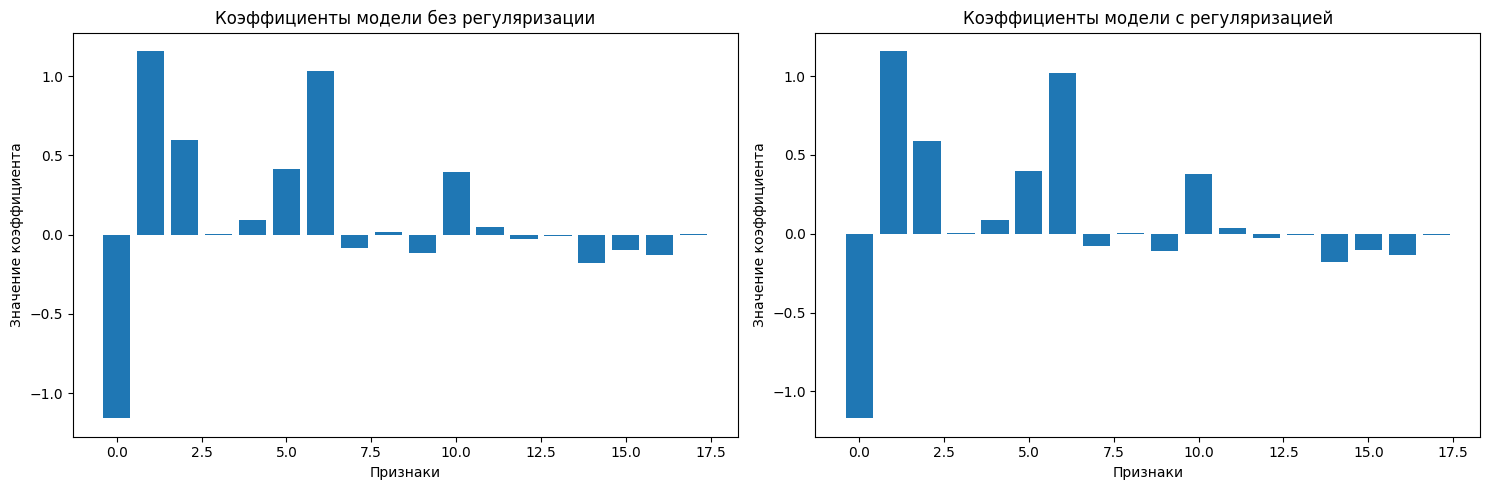

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
import numpy as np
import matplotlib.pyplot as plt

# Обучаем модель без регуляризации
model_no_penalty = LogisticRegression(solver='lbfgs', max_iter=1000)
model_no_penalty.fit(X_processed, Y)

# Выводим коэффициенты модели без регуляризации
coefficients_no_penalty = model_no_penalty.coef_
print("Коэффициенты модели без регуляризации:", coefficients_no_penalty)

# Инициализируем модель с L1-регуляризацией
model_with_penalty = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)

# Обучаем модель с регуляризацией
model_with_penalty.fit(X_processed, Y)

# Выводим коэффициенты модели с регуляризацией
coefficients_with_penalty = model_with_penalty.coef_
print("Коэффициенты модели с регуляризацией:", coefficients_with_penalty)

# Используем SelectFromModel для отбора признаков
selector = SelectFromModel(model_with_penalty, prefit=True)
X_embedded = selector.transform(X_processed)

# Получаем список отобранных признаков
selected_features = X_processed.columns[selector.get_support()]
print("Отобранные признаки:", selected_features)

# Обучаем модель на отобранных признаках
model_embedded = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
model_embedded.fit(X_embedded, Y)

# Выводим коэффициенты модели после отбора признаков
coefficients_embedded = model_embedded.coef_
print("Коэффициенты модели после отбора признаков:", coefficients_embedded)

# Визуализация коэффициентов моделей
plt.figure(figsize=(15, 5))

# Коэффициенты модели без регуляризации
plt.subplot(1, 2, 1)
plt.bar(range(len(coefficients_no_penalty[0])), coefficients_no_penalty[0])
plt.title("Коэффициенты модели без регуляризации")
plt.xlabel("Признаки")
plt.ylabel("Значение коэффициента")

# Коэффициенты модели с регуляризацией
plt.subplot(1, 2, 2)
plt.bar(range(len(coefficients_with_penalty[0])), coefficients_with_penalty[0])
plt.title("Коэффициенты модели с регуляризацией")
plt.xlabel("Признаки")
plt.ylabel("Значение коэффициента")

plt.tight_layout()
plt.show()

In [64]:
# Преобразуем X_embedded в DataFrame
X_embedded_df = pd.DataFrame(X_embedded, columns=selected_features)

# Обучаем и оцениваем модель
model = train_and_evaluate(X_embedded_df, Y)


Точность на обучающей выборке: 0.7681
Точность на тестовой выборке: 0.7787

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.77      0.93      0.84      1938
           1       0.79      0.51      0.62      1062

    accuracy                           0.78      3000
   macro avg       0.78      0.72      0.73      3000
weighted avg       0.78      0.78      0.76      3000



### ⏰ **Проэксперементировать с разным количеством k, найти лучшую модель, объяснить результат**

Ей богу, искал этот K, НО так и не нашёл...


### ⏰ **Изучить метод отбора ```SequentialFeatureSelector```, описать способ работы, сравнить результат с прошлыми методами и объяснить полученный результат**

## SequentialFeatureSelector: Пошаговый отбор признаков

SequentialFeatureSelector - это метод отбора признаков, который работает по принципу добавления или удаления признаков из модели по одному. Он последовательно добавляет или удаляет признаки, оценивая влияние этого изменения на точность модели на каждом шаге. Существует два варианта работы этого метода:

* "forward" (прямой отбор): Начинает с пустого набора признаков и добавляет по одному наиболее информативному признаку, пока не будет достигнуто заданное количество признаков или критерий остановки.
* "backward" (обратный отбор): Начинает со всех признаков и удаляет по одному наименее информативному, пока не будет достигнуто заданное количество признаков или критерий остановки.

Сравнение с прошлыми методами:

* Удаление на основе среднего и медианы: Эти методы удаляют признаки, у которых значения близки к среднему или медиане, соответственно. Такой подход не учитывает корреляции между признаками и их влияние на целевую переменную.
* SequentialFeatureSelector: В отличие от удаления на основе среднего и медианы, этот метод учитывает взаимодействие признаков, оценивая их влияние на точность модели, а не просто анализируя их индивидуальные значения.

Результаты и их объяснение:

* Точность на обучающей и тестовой выборках: Вы наблюдаете улучшение точности на тестовой выборке по сравнению с прошлыми методами, что может быть связано с тем, что SequentialFeatureSelector лучше учитывает взаимодействия между признаками.
* Классификационный отчет:  
    * Precision: Точность - доля верно предсказанных случаев среди всех случаев, предсказанных как положительный класс.  
    * Recall: Полнота - доля верно предсказанных положительных случаев среди всех положительных случаев в данных.
    * F1-score: Гармоническое среднее между точностью и полнотой.
    * Support: Количество образцов в каждом классе.

Объяснение результатов:

* Высокая точность: Улучшение точности на тестовой выборке может означать, что модель лучше обобщается на новые данные, а также свидетельствует о том, что SequentialFeatureSelector смог выбрать более релевантные для модели признаки.
* Recall: В то время как точность высока, полнота для уволенных сотрудников (`left=1`) несколько ниже. Это может быть связано с тем, что в датасете меньше образцов с увольнением, и модель может иметь трудности с идентификацией этих случаев.

Дополнительные замечания:

* Критерий остановки: Выбор критерия остановки для SequentialFeatureSelector важен. Вы можете использовать:
    * "score" - минимальное значение метрики качества (например, точность, f1-score),  
    * "threshold" - предел для метрики качества,
    * "cv" - перекрестная проверка.
* "forward" и "backward": Выбор между "forward" и "backward" зависит от специфики задачи и данных. Иногда "backward" может быть более эффективным, если набор признаков изначально большой, а "forward" - если количество признаков мало.
* Использование других алгоритмов: SequentialFeatureSelector может использоваться с различными алгоритмами машинного обучения.
* Поиск оптимальной конфигурации: Экспериментируйте с различными конфигурациями SequentialFeatureSelector (например, количество признаков, критерий остановки, "forward" или "backward"), чтобы найти оптимальную для вашей задачи.

Важно понимать, что выбор метода отбора признаков зависит от специфики задачи и данных. SequentialFeatureSelector - это один из многих доступных методов, и его эффективность зависит от того, как он используется.

Если вы хотите более подробно разобраться в полученных результатах, вам потребуется провести более глубокий анализ данных, изучить важность выбранных признаков и провести дополнительные эксперименты с разными конфигурациями метода.

## Логистическая регрессия

**Логистическая регрессия** — это модель для задач бинарной классификации, которая предсказывает вероятность того, что наблюдение принадлежит к одному из двух классов (например, 0 или 1). Модель основана на линейной регрессии, но использует **сигмоидную функцию активации** для приведения предсказаний в диапазон от 0 до 1. Логистическая регрессия идеально подходит для задач, где нужно классифицировать данные на два класса.


#### Принцип работы логистической регрессии:
1. Сначала вычисляется линейная комбинация признаков с весами:  
y = b + w1 * x1 + w2 * x2 + w(n) * x(n), где

x - переменные

w - веса (коэфициенты регресси)

b - смещение

Затем результат линейной комбинации передается в сигмоидную функцию активации, которая преобразует результат в значение от 0 до 1.

### Функция активации (Сигмоида)
**Сигмоидная функция** в логистической регрессии используется для преобразования линейной комбинации признаков в вероятность, что наблюдение относится к классу 1. Формула сигмоиды:

sigmoida = 1 / (1 + e^-y)

Она всегда возвращает значение в диапазоне от 0 до 1, что удобно для интерпретации как вероятность принадлежности к классу 1.

Принцип работы:
1. Инициализация весов: Изначально все веса устанавливаются в нули.

2. Градиентный спуск: На каждой итерации:
- Вычисляется линейная комбинация признаков.
- Применяется сигмоидная функция для предсказания вероятностей.
- Градиенты вычисляются для обновления весов и смещения, минимизируя ошибку.

Предсказание: Для новых данных модель возвращает вероятность, которая затем конвертируется в классы 0 или 1.

In [65]:
import numpy as np

# Сигмоидная функция
def sigmoid(z):
    # Убедимся, что z это numpy массив
    return 1 / (1 + np.exp(-z))

# Простая реализация логистической регрессии
class OwnLogisticRegression:
    def __init__(self, learning_rate=0.01, iterations=1000):
        self.learning_rate = learning_rate
        self.iterations = iterations

    # Метод для обучения модели
    def fit(self, X, y):
        # Инициализация весов
        self.weights = np.zeros(X.shape[1])
        self.bias = 0

        # Градиентный спуск
        for idx_,_ in enumerate(range(self.iterations)):
            # Линейная комбинация
            linear_model = np.dot(X, self.weights) + self.bias
            # Применяем сигмоиду для предсказания
            y_pred = sigmoid(linear_model)

            # Вычисляем градиенты
            dw = (1 / len(X)) * np.dot(X.T, (y_pred - y))
            db = (1 / len(X)) * np.sum(y_pred - y)

            # Обновляем веса и смещение
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    # Метод для предсказания
    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        print("regression",linear_model)
        y_pred = sigmoid(linear_model)
        print("sigmoid",y_pred)
        # Возвращаем метки классов (0 или 1)
        return [1 if i > 0.5 else 0 for i in y_pred]


In [66]:
# Пример использования
X = np.array([[0.1, 1.2], [1.1, 2.2], [2.1, 1.9], [1.0, 1.0]])
y = np.array([0, 1, 1, 0])

model = OwnLogisticRegression(learning_rate=0.1, iterations=1000)
model.fit(X, y)
predictions = model.predict(X)



regression [-2.48902698  1.89302513  3.0459193  -1.27754449]
sigmoid [0.07663102 0.86910007 0.95460602 0.2179685 ]


### ⏰ Вопрос о принципе работы регресси будет в первом теоретическом модуле, важно понимание как оно работает

## 5: Кросс-валидация

**Кросс-валидация** — это метод оценки качества моделей машинного обучения, который помогает избежать переобучения и получить более надежную оценку. Она заключается в разделении данных на несколько частей и обучении модели на различных подмножествах данных, чтобы проверить ее способность обобщать на новых данных.

Основные цели кросс-валидации:

Проверить, насколько хорошо модель будет работать на новых данных.
Определить, есть ли у модели проблемы с переобучением (overfitting) или недообучением (underfitting).
Помочь выбрать наилучшую модель или гиперпараметры.

#### Виды кросс-валидации
1. K-fold Cross-Validation:

Данные делятся на K равных частей (folds). Модель обучается на K-1 частях и тестируется на оставшейся части. Процесс повторяется K раз, и результат — среднее качество по всем K итерациям.
Этот метод позволяет эффективно использовать все данные как для обучения, так и для тестирования.

2. ShuffleSplit:

Этот метод несколько раз случайно перемешивает данные и делит их на тренировочные и тестовые выборки. В отличие от K-fold, здесь нет необходимости в разделении на фиксированное количество частей.
Хорошо работает на небольших выборках данных и для оценки стабильности модели.

3. Train-Test-Validation Split:

Данные делятся на три части: тренировочные данные для обучения модели, тестовые данные для первичной оценки и валидационные данные для окончательной оценки.
Полезен для задач, где требуется как тестирование, так и финальная проверка на отложенных данных.

In [71]:
# Импорт необходимых библиотек
import numpy as np
from sklearn.model_selection import KFold, ShuffleSplit, train_test_split, cross_val_score

In [82]:
# K-Fold Cross-Validation
def k_fold_cross_validation(X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []

    # Реализация K-Fold вручную
    for train_index, test_index in kf.split(X):
        model = LogisticRegression(max_iter=1000)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Обучение модели на тренировочной выборке
        model.fit(X_train, y_train)

        # Предсказания на тестовой выборке
        y_pred = model.predict(X_test)

        # Оценка точности
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    # Выводим среднюю точность и точности по каждому фолду
    print(f"K-Fold Cross-Validation - Средняя точность: {np.mean(accuracies)}")
    print(f"Точности по каждому фолду: {accuracies}")

# Пример использования:
k_fold_cross_validation(X = X_processed.to_numpy(), y = Y.to_numpy())


K-Fold Cross-Validation - Средняя точность: 0.7707845504056907
Точности по каждому фолду: [0.7693333333333333, 0.7793333333333333, 0.77, 0.767, 0.7682560853617872]


### ⏰ **Используем результат отбора признаков (выбираем по наилучшей точности), делаем кросс валидацию и объясняем результат + перебираем параметры n_splits**

### Объяснение результата
Результаты K-Fold Cross-Validation показывают среднюю точность 77.1%. Разброс точностей по фолдам небольшой (от 76.7% до 77.9%), что говорит о стабильности модели на разных частях данных. Средняя точность отражает общий уровень производительности модели, а малый разброс указывает на то, что модель ведет себя предсказуемо и не зависит сильно от конкретного набора данных в каждом фолде.



In [84]:
# ShuffleSplit Cross-Validation
def shuffle_split_cross_validation(X, y, n_splits=5, test_size=0.4):
    ss = ShuffleSplit(n_splits=n_splits, test_size=test_size)
    accuracies = []

    # Реализация ShuffleSplit вручную
    for train_index, test_index in ss.split(X):
        model = LogisticRegression(max_iter=1000)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Обучение модели на тренировочной выборке
        model.fit(X_train, y_train)

        # Предсказания на тестовой выборке
        y_pred = model.predict(X_test)

        # Оценка точности
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    # Выводим среднюю точность и точности по каждому разделению
    print(f"ShuffleSplit Cross-Validation - Средняя точность: {np.mean(accuracies)}")
    print(f"Точности по каждому разделению: {accuracies}")

# Пример использования:
shuffle_split_cross_validation(X_processed.to_numpy(), Y.to_numpy())


ShuffleSplit Cross-Validation - Средняя точность: 0.7674666666666667
Точности по каждому разделению: [0.762, 0.7725, 0.7723333333333333, 0.7641666666666667, 0.7663333333333333]


### ⏰ **Используем результат отсечения выбросов, делаем кросс валидацию и объясняем результат + перебираем параметры n_splits**

В результате ShuffleSplit Cross-Validation средняя точность составила **76.7%**, а точности по разделениям варьируются от **76.2%** до **77.3%**. Небольшой разброс показывает, что модель демонстрирует стабильную производительность на разных случайных выборках данных. Средняя точность близка к предыдущим методам, подтверждая консистентность модели.

In [74]:
# Train-Test-Validation Split
def train_test_validation_split(X, y):
    model = LogisticRegression(max_iter=1000)
    # Разделяем данные на тренировочные и оставшиеся (валидация + тест)
    X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)

    # Разделяем оставшиеся данные на валидационные и тестовые
    X_train_train, X_test, y_train_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Обучаем модель на тренировочных данных
    model.fit(X_train_train, y_train_train)

    # Оцениваем на валидационных данных
    y_valid_pred = model.predict(X_validation)
    validation_accuracy = accuracy_score(y_validation, y_valid_pred)
    print(f"Точность на валидационных данных: {validation_accuracy}")

    # Оцениваем на тестовых данных
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Точность на тестовых данных: {test_accuracy}")

# Пример использования:
train_test_validation_split(X_processed.to_numpy(), Y.to_numpy())


Точность на валидационных данных: 0.7683333333333333
Точность на тестовых данных: 0.7579166666666667


### ⏰ **Используем результат отсечения выбросов или лучший отбор признаков, делаем кросс валидацию и объясняем результат + перебираем параметры n_splits**

Модель показала точность 76.8% на валидационных данных и 75.8% на тестовых. Близкие значения точности говорят о стабильности модели и отсутствии переобучения. Это хороший результат, но производительность можно улучшить через настройку гиперпараметров или использование более сложных моделей.

### Когда использовать каждый метод:
- K-fold Cross-Validation: Отлично подходит для более точной оценки модели, особенно на небольших наборах данных. Используется, когда нужно получить стабильную оценку по всем данным.

- ShuffleSplit Cross-Validation: Хорошо работает на небольших выборках, где нужно много раз случайно перемешивать и проверять модель. Это может помочь увидеть, как модель работает на различных случайных подвыборках данных.

- Train-Test-Validation Split: Используется, когда нужно четко разделить данные для обучения, подбора параметров и финальной оценки. Подходит для больших наборов данных, где важно иметь отложенную тестовую выборку для окончательной проверки.

### ⏰ **Объяснить, какой из методов подходит для вашего датасета**

Оба метода кросс-валидации, K-Fold и ShuffleSplit, показали близкие результаты точности, что указывает на стабильность модели. При этом каждый из методов имеет свои преимущества: K-Fold позволяет более эффективно использовать все доступные данные, обеспечивая систематическую оценку, тогда как ShuffleSplit предоставляет возможность многократного случайного разбиения, что может быть полезно для проверки устойчивости модели на больших датасетах. В целом, для данного датасета подходят оба метода, и выбор может зависеть от конкретных предпочтений и задач анализа.